In [1]:
import os
import ollama
from anytree import PreOrderIter
import json
from naive_baseline import generate_naive_baseline
from utils import generate_formal_explanations, make_decision
import pandas as pd

In [2]:
model_name = "llama3" # "mistral"

### Changed pipeline a bit, added preorder_traversal list to follow the order in which the agent decides what to do;
### function generate_comprehensive_explanation generates response from mistral https://ollama.com/library/mistral

In [ ]:
def preorder_traversal(root):
    """
    Performs a preorder traversal of a tree and returns a list of node names.
    
    :param root: The root node of the tree.
    :return: A list of node names in preorder traversal order.
    """
    preorder_traversal_nodes = []
    
    for node in PreOrderIter(root):
        current_node_name = node.name
        preorder_traversal_nodes.append(current_node_name)
    
    return preorder_traversal_nodes

def generate_natural_language_explanation(json_tree, naive_explanation, formal_explanations, tree_traversal_order, 
                                     norm, beliefs, goal, preferences, action_to_explain, chosen_trace=None, bad_example=""):
    
    # Format key context elements in plain English
    norm_str = norm if norm else "None"
    beliefs_str = ", ".join(beliefs) if beliefs else "None"
    goal_str = goal if goal else "None"
    pref_description = f"{preferences[0]} with priority {preferences[1]}"
    chosen_trace_str = ", ".join(chosen_trace) if chosen_trace else "None"

    prompt = f"""
    I am an agent making decisions based on my beliefs, goals, and restrictions. Your task is to **rewrite my naive explanation 
    into a natural, first-person account** while keeping all reasoning intact.

    ### CONTEXT
    - **Action to explain**: '{action_to_explain}'  
    - **Chosen path**: {chosen_trace_str}  
    - **Initial beliefs**: {beliefs_str}  
    - **Norms/restrictions**: {norm_str}  
    - **Goal**: {goal_str}  
    - **Preferences**: {pref_description}  
    - **Tree traversal order**: {tree_traversal_order}  
    - **Naive explanation**: {naive_explanation}  

    ### INSTRUCTIONS
    - Rewrite the explanation in **first-person**, as if I (the agent) am telling the story of my decision-making. 
    - Start your answer natrually, as if you are explaining to a friend. 
    - Assume you start at 'getCoffee' root node so you don't need to explain it.
    - Follow the same **reasoning order** as my naive explanation.  
    - Start by explaining my **beliefs, goals, and restrictions naturally** (avoid lists).  
    - If you have an action to explain that is not in the path, explain why I didn't choose it and the path I took instead.
    - Do not compare options that are part of the same path.
    - Note that a lower cost for action attribute means a better option so pharse it in a way that the reader understands that.
    - Do not reveal the numerical costs of the actions. Instead, explain the reasoning behind the decisions. For time, a lower value means the action is quicker; for price, a lower value means it is cheaper; and for quality, a lower value means it is better. (This may seem counterintuitive, but it reflects the given logic.)
    - Walk through my **thought process step by step**, describing options I considered, why I rejected some, and how I made my choices.  
    - If '{action_to_explain}' was **not chosen**, explain why in a way that feels natural and clear.  
    - Keep it **conversational and engaging**, avoiding generic or robotic phrasing.  

    **DO NOT:**  
    - Use section headings or bullet points.  
    - State information in a dry, factual way without making it flow naturally.  
    - Add anything new—just improve clarity and expressiveness.  
    - Say you didn't do a step you actually did.
    - Use vague answers like "just in case I needed them" or "It just didn't seem like the best option for me at this point" use only info you were given and don't invent anything new.

    I want my explanation to sound like **I'm actually explaining my reasoning to someone** rather than listing facts.
    """
    
    # Send the prompt to your LLM
    messages = [
        {
            'role': 'user',
            'content': prompt
        }
    ]
    
    # response = requests.post(f"{api_base}/chat", json={"model": "mistral", "messages": messages})
    
    response = ollama.chat(model=model_name, messages=messages)
    
    try:
        return response['message']['content']
    except Exception as e:
        print(f"JSONDecodeError: {e}")
        return None

#### Integrated here llm explanations and save them into explanations/mistral

In [ ]:
def generate_explanations_for_inputs(test_cases, cases_to_do):
    """
    Generate explanations for the inputs test cases
    :param test_cases: dictionary containing the test cases
    :param cases_to_do: list of test cases to actually generate explanations for (for easy re-running)
    :return: dictionary containing the explanations for each test case
    """
    
    # in .ipynb current directory is extracted like this
    current_dir = os.getcwd()

    baseline_explanations_dir = os.path.join(current_dir, "explanations", "baseline")
    os.makedirs(baseline_explanations_dir, exist_ok=True)


    llm_explanations_dir = os.path.join(current_dir, "explanations", model_name)
    
    baseline_explanations = {}
    llm_explanations = {}
    for index, row in test_cases.iterrows():    
        if index not in cases_to_do:
            continue 
        print(f"Processing test case {index}")   
        # Read the JSON file into a dictionary
        with open(f'{current_dir}/{row["name_json_tree_file"]}', 'r') as file:
            json_tree = json.load(file)
        # Generate formal explanations
        formal_explentions, chosen_trace = generate_formal_explanations(json_tree=json_tree, norm=row["norm"], beliefs=row["beliefs"], goal=row["goal"], preferences=row["preferences"], action_to_explain=row["action_to_explain"])
        baseline_explanations[index] = generate_naive_baseline(formal_explentions=formal_explentions, chosen_trace=chosen_trace, norm=row["norm"], beliefs=row["beliefs"], goal=row["goal"], preferences=row["preferences"], action_to_explain=row["action_to_explain"])



        root, chosen_trace, valid_traces, valid_costs = make_decision(json_tree, norm=row["norm"], goal=row["goal"], beliefs=row["beliefs"], preferences=row["preferences"], output_dir='/')
        tree_traversal_order = preorder_traversal(root=root)

        # read bad example file
        bad_example_file = os.path.join(current_dir, "explanations", "bad", f"{index}.txt")
        bad_example = ""
        with open(bad_example_file, 'r') as file:
            bad_example = file.read()


        llm_explanations[index] = generate_natural_language_explanation(
                        json_tree=json_tree,
                        naive_explanation=baseline_explanations[index],
                        formal_explanations=formal_explentions,
                        tree_traversal_order=tree_traversal_order,
                        norm=row["norm"],
                        beliefs=row["beliefs"],
                        goal=row["goal"],
                        preferences=row["preferences"],
                        action_to_explain=row["action_to_explain"],
                        chosen_trace=chosen_trace,
                        bad_example=bad_example
                        )

        # Save each explanation to a separate text file
        baseline_explanation_file = os.path.join(baseline_explanations_dir, f"{index}.txt")
        with open(baseline_explanation_file, 'w') as f:
            for explanation in baseline_explanations[index]:
                f.write(explanation + '\n')


        os.makedirs(llm_explanations_dir, exist_ok=True)  

        llm_explanation_file = os.path.join(llm_explanations_dir, f"{index}.txt")

        print(f"directory ---> {llm_explanation_file}")
        
        # Loop through the dictionary and write explanations for each test case
        with open(llm_explanation_file, 'w') as f:
            for explanation in llm_explanations[index]:
                # Write the explanation for this test case
                f.write(explanation)   # Add an extra newline for separation

        
    
    return baseline_explanations, llm_explanations

In [5]:
test_cases = [
    {
        "name_json_tree_file": "coffee.json",
        "norm": {"type": "P", "actions": ["payShop"]},
        "beliefs": ["staffCardAvailable", "ownCard", "colleagueAvailable", "haveMoney", "AnnInOffice"],
        "goal": ["haveCoffee"],
        "preferences": [["quality", "price", "time"], [1, 2, 0]],
        "action_to_explain": "payShop"
    },
    {
        "name_json_tree_file": "coffee.json",
        "norm": {},
        "beliefs": ["staffCardAvailable", "ownCard"],
        "goal": ["haveCoffee"],
        "preferences": [["quality", "price", "time"], [0, 1, 2]],
        "action_to_explain": "getCoffeeKitchen"
    },
    {
        "name_json_tree_file": "coffee.json",
        "norm": {},
        "beliefs": ["haveMoney", "AnnInOffice"],
        "goal": ["haveCoffee"],
        "preferences": [["quality", "price", "time"], [0, 1, 2]],
        "action_to_explain": "getCoffeeShop"
    },
    {
        "name_json_tree_file": "coffee.json",
        "norm": {"type": "P", "actions": ["gotoAnnOffice"]},
        "beliefs": ["staffCardAvailable", "ownCard", "colleagueAvailable", "haveMoney", "AnnInOffice"],
        "goal": ["haveCoffee"],
        "preferences": [["quality", "price", "time"], [0, 1, 2]],
        "action_to_explain": "payShop"
    },
    {
        "name_json_tree_file": "coffee.json",
        "norm": {"type": "P", "actions": ["payShop"]},
        "beliefs": ["staffCardAvailable", "ownCard", "colleagueAvailable", "haveMoney"],
        "goal": ["haveCoffee"],
        "preferences": [["quality", "price", "time"], [1, 2, 0]],
        "action_to_explain": "gotoKitchen"
    }
]

df_test_cases = pd.DataFrame(test_cases, index=[f"test_case_{i+1}" for i in range(len(test_cases))])

In [6]:
cases_to_do = ["test_case_1", "test_case_2", "test_case_3", "test_case_4", "test_case_5"]
baseline_explanations, llm_explanations = generate_explanations_for_inputs(df_test_cases, cases_to_do)

Processing test case test_case_1
Chosen trace: ['getCoffee', 'getKitchenCoffee', 'getStaffCard', 'getOwnCard', 'gotoKitchen', 'getCoffeeKitchen']
Action to explain: payShop not in trace
directory ---> c:\Users\bar24\OneDrive - Universiteit Utrecht\Documents\School\UU Data Sceince MSc\1st Year\Period 3\Explainable AI - INFOMXAI\Assignments\Project2\ExplainableAI-Project2\Part2\explanations\llama3\test_case_1.txt
Processing test case test_case_2
Chosen trace: ['getCoffee', 'getKitchenCoffee', 'getStaffCard', 'getOwnCard', 'gotoKitchen', 'getCoffeeKitchen']
Action to explain: getCoffeeKitchen in trace
Ancestor names: ['getCoffee', 'getKitchenCoffee']
directory ---> c:\Users\bar24\OneDrive - Universiteit Utrecht\Documents\School\UU Data Sceince MSc\1st Year\Period 3\Explainable AI - INFOMXAI\Assignments\Project2\ExplainableAI-Project2\Part2\explanations\llama3\test_case_2.txt
Processing test case test_case_3
Chosen trace: ['getCoffee', 'getShopCoffee', 'gotoShop', 'payShop', 'getCoffeeShop

### Ploting for report

In [27]:
import numpy as np
import pandas as pd

# Data for each case (mean ± SD)
data = {
    "Case 1": [(3.09, 1.64), (3.64, 1.36), (3.18, 1.54), (3.18, 1.47), (4.27, 1.42), (3.09, 1.30)],
    "Case 2": [(4.00, 1.18), (4.27, 0.90), (4.27, 1.01), (4.36, 0.92), (4.73, 0.47), (3.64, 0.92)],
    "Case 3": [(4.00, 0.77), (4.09, 0.94), (4.36, 0.81), (4.36, 0.92), (4.73, 0.65), (3.73, 0.90)],
    "Case 4": [(3.92, 0.79), (4.08, 1.00), (4.00, 1.04), (4.00, 0.85), (4.67, 0.78), (3.75, 1.14)],
    "Case 5": [(3.91, 0.83), (4.27, 0.65), (4.27, 0.79), (4.27, 0.90), (4.73, 0.65), (3.55, 0.82)],
}

# Calculate overall mean and SD
overall_means = []
overall_sds = []

for i in range(len(data["Case 1"])):
    means = [data[case][i][0] for case in data]
    sds = [data[case][i][1] for case in data]
    
    # Overall mean
    overall_mean = np.mean(means)
    
    # Overall SD (pooled standard deviation)
    overall_sd = np.sqrt(np.mean([sd**2 for sd in sds]))
    
    overall_means.append(overall_mean)
    overall_sds.append(overall_sd)

# Print results
for i, (mean, sd) in enumerate(zip(overall_means, overall_sds), start=1):
    print(f"Row {i}: Overall Mean = {mean:.2f}, Overall SD = {sd:.2f}")

Row 1: Overall Mean = 3.78, Overall SD = 1.09
Row 2: Overall Mean = 4.07, Overall SD = 1.00
Row 3: Overall Mean = 4.02, Overall SD = 1.07
Row 4: Overall Mean = 4.03, Overall SD = 1.04
Row 5: Overall Mean = 4.63, Overall SD = 0.86
Row 6: Overall Mean = 3.55, Overall SD = 1.03


Excel file path: c:\Users\bar24\OneDrive - Universiteit Utrecht\Documents\School\UU Data Sceince MSc\1st Year\Period 3\Explainable AI - INFOMXAI\Assignments\Project2\ExplainableAI-Project2\Part2\explanations\reviews\collected reviews answers.xlsx


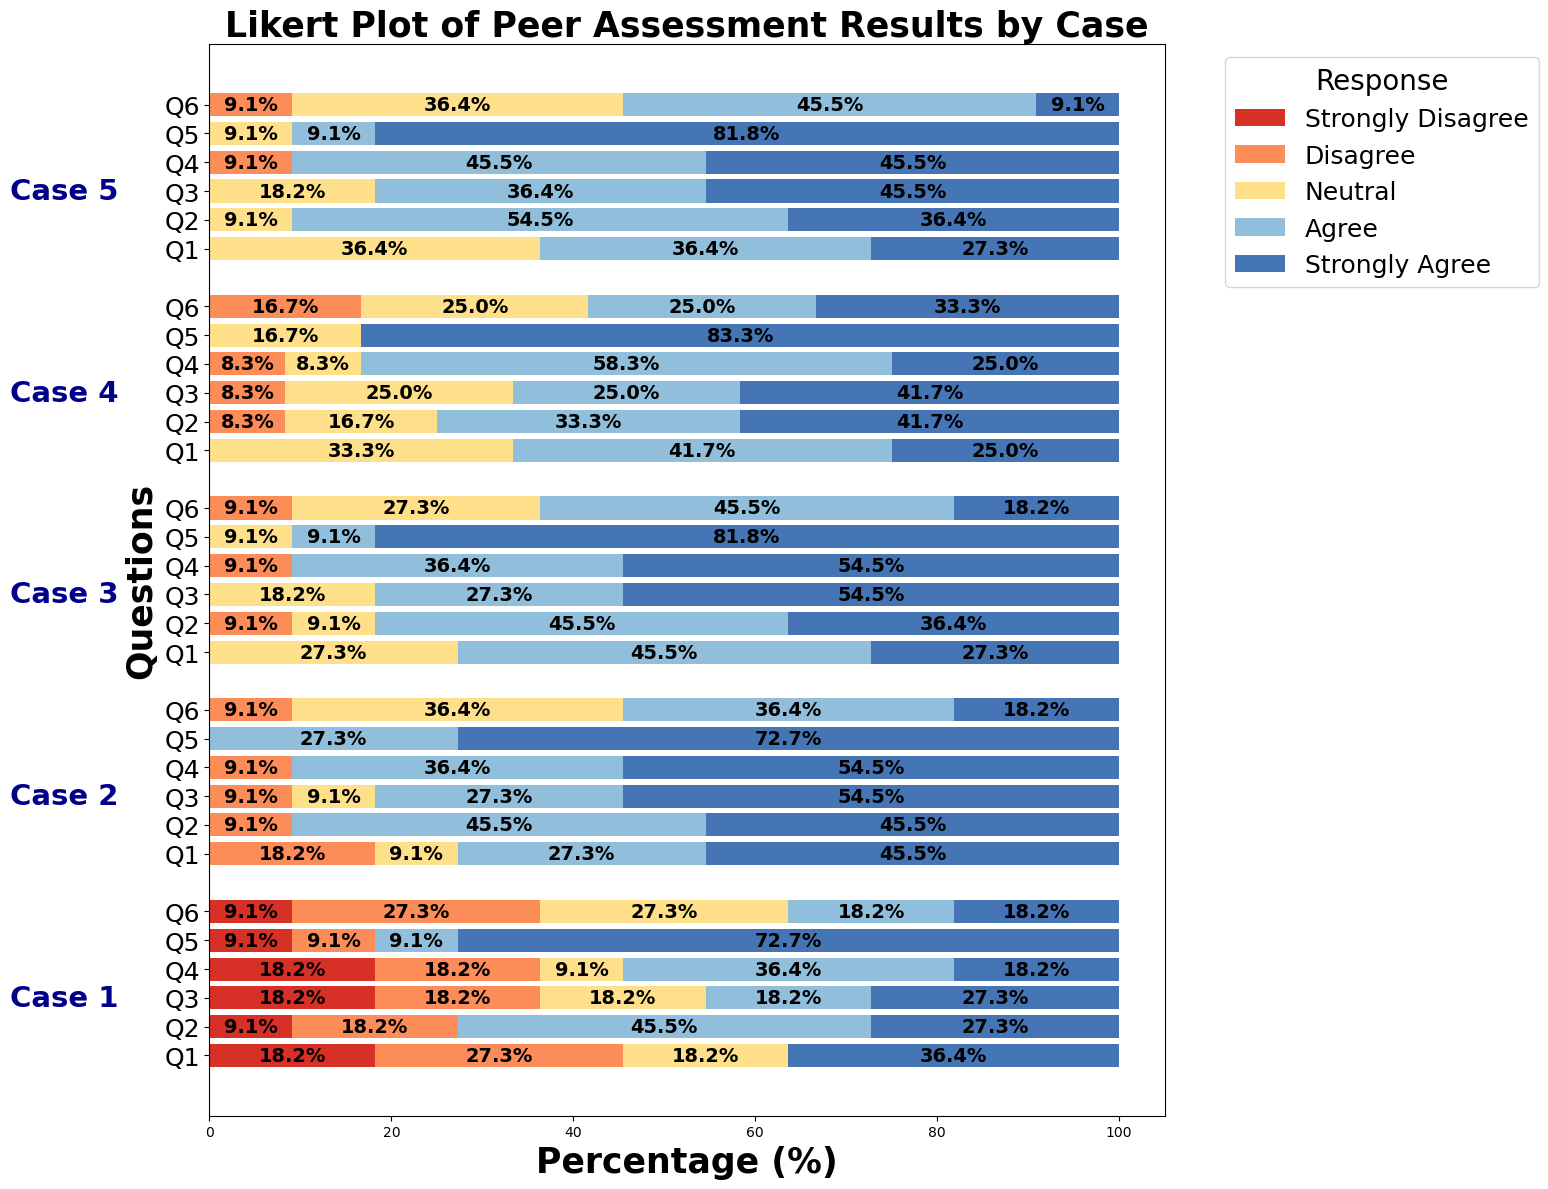

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Load data from Excel file
current_dir = os.getcwd()
reviews_dir = os.path.join(current_dir, "explanations", "reviews")
excel_file = f"{reviews_dir}\\collected reviews answers.xlsx"  # Replace with your Excel file path
print(f"Excel file path: {excel_file}")

tabs = [f"Input {i}" for i in range(1, 6)]  # Tabs for each case (Input1, Input2, ..., Input5)

# Initialize an empty DataFrame to store combined data
all_cases_data = pd.DataFrame()

# Read each tab and process the data
for case_index, tab in enumerate(tabs, start=1):
    df = pd.read_excel(excel_file, sheet_name=tab)
    
    # Assign shortened labels (Q1, Q2, ...) to the questions
    df["Short Question"] = [f"Q{i+1}" for i in range(len(df))]
    
    # Add a column to indicate the case (e.g., Case 1, Case 2, ...)
    df["Case"] = f"Case {case_index}"
    
    # Combine the data
    all_cases_data = pd.concat([all_cases_data, df], ignore_index=True)

# Process the data to calculate the distribution of responses
response_columns = [col for col in all_cases_data.columns if col.startswith("Answer")]  # Columns with individual responses
likert_data = pd.DataFrame()

# Calculate the count of each Likert scale category for each question in each case
for _, row in all_cases_data.iterrows():
    counts = pd.Series(row[response_columns].value_counts(), index=[1, 2, 3, 4, 5]).fillna(0)
    counts["Short Question"] = row["Short Question"]
    counts["Case"] = row["Case"]
    likert_data = pd.concat([likert_data, counts.to_frame().T], ignore_index=True)

# Pivot the data to prepare for plotting
likert_data = likert_data.set_index(["Case", "Short Question"])
likert_data = likert_data[[1, 2, 3, 4, 5]].rename(columns={1: "Strongly Disagree", 2: "Disagree", 3: "Neutral", 4: "Agree", 5: "Strongly Agree"})

# Normalize the data to percentages
likert_data_normalized = likert_data.div(likert_data.sum(axis=1), axis=0) * 100

# Create a diverging stacked bar chart for all cases in a single plot
categories = ["Strongly Disagree", "Disagree", "Neutral", "Agree", "Strongly Agree"]
colors = ["#d73027", "#fc8d59", "#fee08b", "#91bfdb", "#4575b4"]

fig, ax = plt.subplots(figsize=(16, 12))

# Prepare data for plotting
case_offsets = {case: i * (len(likert_data_normalized.loc[case]) + 1) for i, case in enumerate(likert_data_normalized.index.get_level_values("Case").unique())}
y_positions = []

for case, offset in case_offsets.items():
    case_data = likert_data_normalized.loc[case]
    y_pos = np.arange(len(case_data)) + offset
    y_positions.extend(y_pos)
    
    left = np.zeros(len(case_data))
    for category, color in zip(categories, colors):
        bars = ax.barh(y_pos, case_data[category], left=left, color=color, label=category if case == "Case 1" else "")
        
        # Add percentage labels to each bar
        for bar in bars:
            width = bar.get_width()
            if width > 2:  # Only add labels if the segment is wide enough
                ax.text(bar.get_x() + width / 2, bar.get_y() + bar.get_height() / 2,
                        f"{width:.1f}%", ha="center", va="center", fontsize=14, color="black", weight="bold")
        
        left += case_data[category]

# Add case labels as separators
for case, offset in case_offsets.items():
    ax.text(-10, offset + 2, case, fontsize=21, fontweight="bold", ha="right", va="center", color="darkblue")

# Add labels, title, and legend
ax.set_title("Likert Plot of Peer Assessment Results by Case", fontsize=25, fontweight="bold")
ax.set_xlabel("Percentage (%)", fontsize=25, fontweight="bold")
ax.set_ylabel("Questions", fontsize=25, fontweight="bold")
ax.set_yticks(y_positions)
ax.set_yticklabels([f"{question}" for case, question in likert_data_normalized.index], fontsize=18)
ax.legend(title="Response", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=18, title_fontsize=20)

# Adjust layout and save the plot
plt.tight_layout()
plt.savefig("likert_plot_combined_high_fonts.png", dpi=300)  # Save as high-resolution image
plt.show()